APR Mini Project

***Prepared By- Group 5***

**Signature Forgery Detection**

<a id="1"></a>
# <font size= '6' color='DodgerBlue'>▶ Import Required Libraries</font>

In [1]:
# File Handling & Image Processing
import os
import cv2

# Numerical & Scientific Computing
import numpy as np

# Feature Extraction & Dimensionality Reduction
from skimage.feature import hog
from sklearn.decomposition import PCA

# Model Training
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Evaluation Metrics & Visualization
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# Warning Control
import warnings
warnings.filterwarnings('ignore')

<a id="2"></a>
# <font size= '6' color='DodgerBlue'>▶ Preprocessing and Feature Extraction</font>

In [2]:
def load_images_with_hog(folder_path, label):
    features = []
    labels = []
    images = []

    for filename in os.listdir(folder_path): # Return a List[] of all image names
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):

            # Images Preprocessing
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (200, 200)) # (200 x 200) pixels
            img = cv2.GaussianBlur(img, (3, 3), 0) # kernal (3 x 3) pixels

            # Feature Extraction using (Hog: Histogram of Oriented Gradients)
            hog_features = hog(img, pixels_per_cell=(8, 8), orientations=9,
                               cells_per_block=(2, 2), block_norm='L2-Hys')

            features.append(hog_features)
            labels.append(label)
            images.append(img)

    return np.array(features), np.array(labels), images

<a id="3"></a>
# <font size= '6' color='DodgerBlue'>▶ Load All Datasets (Real and Forged) from Multiple Folders</font>

In [3]:
def load_all_datasets(folder_path):
    X = []
    y = []
    all_images = []

    for i in range(1, 5):
        real_path = os.path.join(folder_path, f'dataset{i}', 'real') if os.path.exists(os.path.join(folder_path, f'dataset{i}', 'real')) else os.path.join(folder_path, f'dataset{i}', 'real1')
        forge_path = os.path.join(folder_path, f'dataset{i}', 'forge')

        X_real, y_real, imgs_real = load_images_with_hog(real_path, 0)
        X_forge, y_forge, imgs_forge = load_images_with_hog(forge_path, 1)

        X.append(X_real) # X = [array1(50, 300), array2(50, 300), array3(50, 300)]
        X.append(X_forge)

        y.append(y_real)
        y.append(y_forge)

        all_images.extend(imgs_real)
        all_images.extend(imgs_forge)

    X = np.concatenate(X, axis=0) # X.shape = (150, 300) To become a single array
    y = np.concatenate(y, axis=0)

    return X, y, all_images

<a id="4"></a>
# <font size= '6' color='DodgerBlue'>▶ List All Subfolders Inside the Main Dataset Folder</font>

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
dataset = '/content/drive/MyDrive/handwritten-signatures/Dataset_Signature_Final/Dataset'

dataset_subfolders = []

for folder_name in os.listdir(dataset):
    full_path = os.path.join(dataset, folder_name)
    if os.path.isdir(full_path):
        dataset_subfolders.append(folder_name)

print("Subfolders Inside Dataset:")
for folder_name in dataset_subfolders:
    print("-", folder_name)

Subfolders Inside Dataset:
- dataset2
- dataset1
- dataset4
- dataset3


<a id="4"></a>
# <font size= '6' color='DodgerBlue'>▶ Counting Real and Forged Signature Images in each Dataset</font>

In [11]:
def count_images(folder):
    count = 0
    for file in os.listdir(folder):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            count += 1
    return count

total_images = 0

for i in range(1, 5):
    dataset_path = os.path.join(dataset, f'dataset{i}')
    real_path = os.path.join(dataset_path, 'real') if os.path.exists(os.path.join(dataset_path, 'real')) else os.path.join(dataset_path, 'real1')
    forge_path = os.path.join(dataset_path, 'forge')

    real_count = count_images(real_path)
    forge_count = count_images(forge_path)

    total_images += real_count + forge_count

    print(f"Number of real images in dataset{i}: {real_count}")
    print(f"Number of forged images in dataset{i}: {forge_count}\n")

print(f"Number of all images: {total_images}\n")

Number of real images in dataset1: 60
Number of forged images in dataset1: 60

Number of real images in dataset2: 60
Number of forged images in dataset2: 60

Number of real images in dataset3: 150
Number of forged images in dataset3: 150

Number of real images in dataset4: 90
Number of forged images in dataset4: 90

Number of all images: 720



<a id="5"></a>
# <font size= '6' color='DodgerBlue'>▶ Dimensionality Reduction using PCA</font>

In [12]:
X, y, all_images = load_all_datasets(dataset)
print("HOG Shape:", X.shape)

HOG Shape: (720, 20736)


In [13]:
pca = PCA(n_components=200, random_state=42)
X_pca = pca.fit_transform(X)
print("After Applying PCA: ", X_pca.shape)

# fit: PCA computes the mean, covariance matrix, eigenvalues, and eigenvectors.
# transform: It projects the original data X into the new space (principal component space).

After Applying PCA:  (720, 200)


<a id="6"></a>
# <font size= '6' color='DodgerBlue'>▶ Split the Dataset into Training and Testing Sets</font>

In [14]:
X_train, X_test, y_train, y_test, img_train, img_test = train_test_split(X_pca, y,
                                            all_images, test_size=0.2, random_state=42)

<a id="7"></a>
# <font size= '6' color='DodgerBlue'>▶ Training SVM Classifier on Training Data</font>

In [15]:
model = SVC(C=10, gamma='auto', kernel='poly', random_state=42)
model.fit(X_train, y_train)

SVC(C=10, gamma='auto', kernel='poly', random_state=42)

<a id="8"></a>
# <font size= '6' color='DodgerBlue'>▶ Evaluate SVM Model Accuracy on Testing Data</font>

In [16]:
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred) * 100
print(f"Testing Accuracy: {test_accuracy:.2f} %")

Testing Accuracy: 94.44 %


<a id="8"></a>
# <font size= '6' color='DodgerBlue'>▶ Visualize and Compare Actual vs Predicted Labels for Test Images</font>

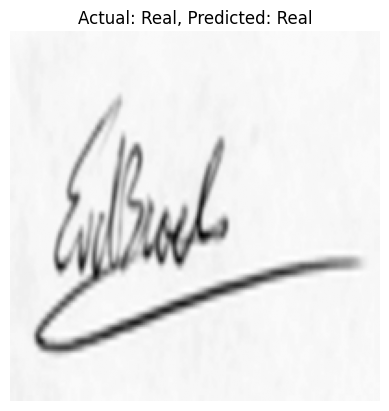

--------------------------------------------------


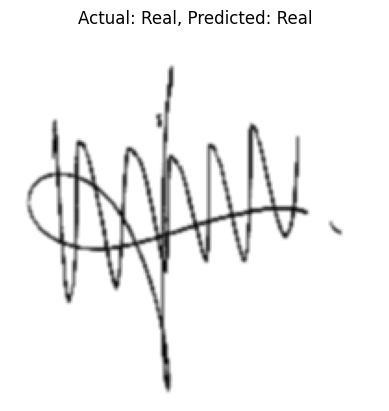

--------------------------------------------------


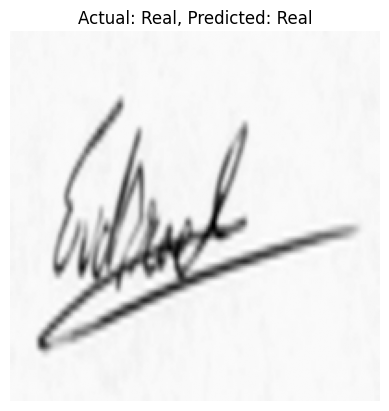

--------------------------------------------------


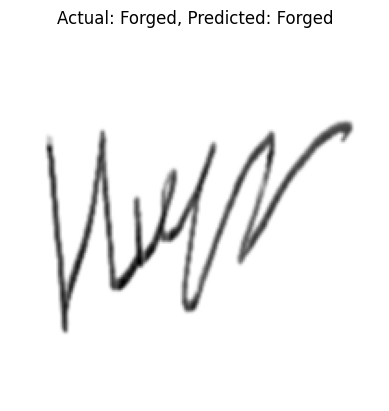

--------------------------------------------------


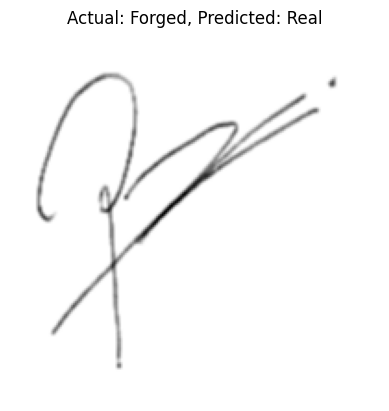

--------------------------------------------------


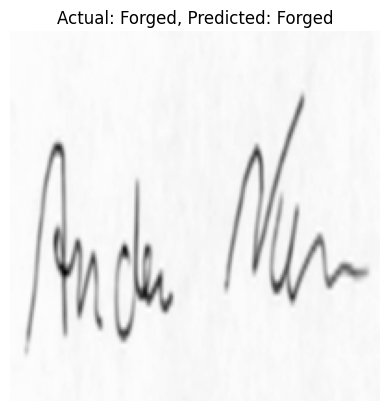

--------------------------------------------------


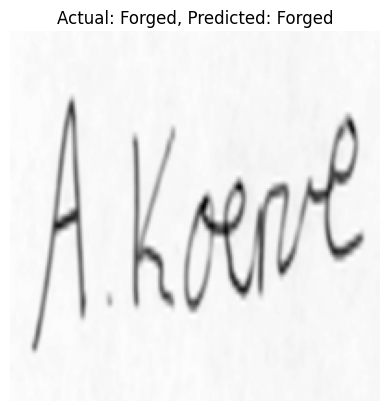

--------------------------------------------------


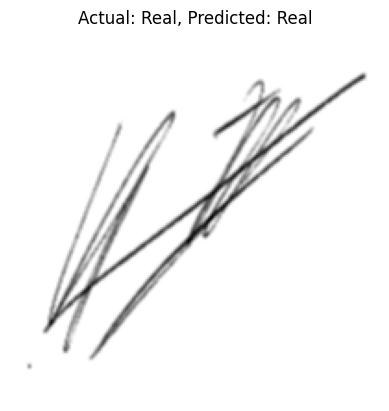

--------------------------------------------------


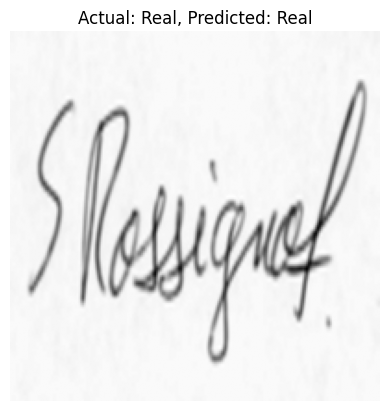

--------------------------------------------------


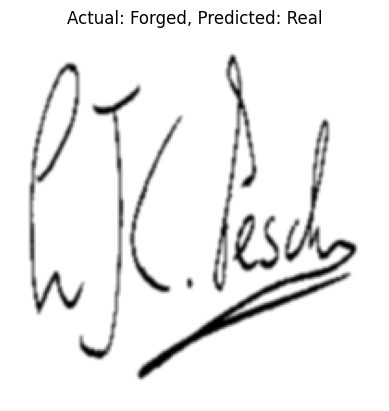

--------------------------------------------------


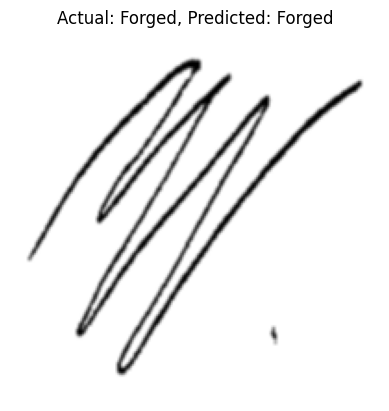

--------------------------------------------------


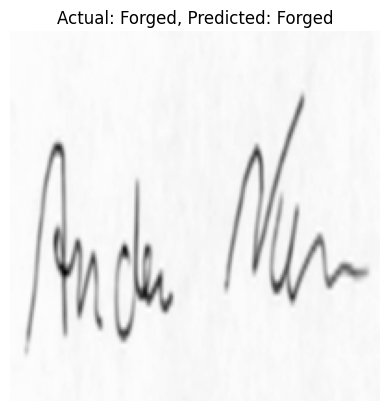

--------------------------------------------------


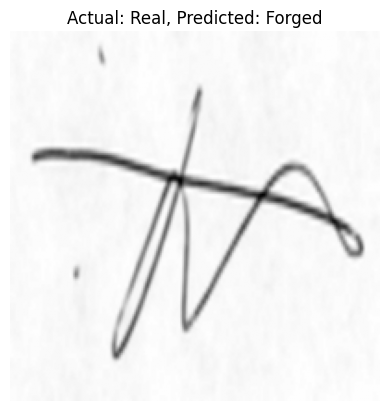

--------------------------------------------------


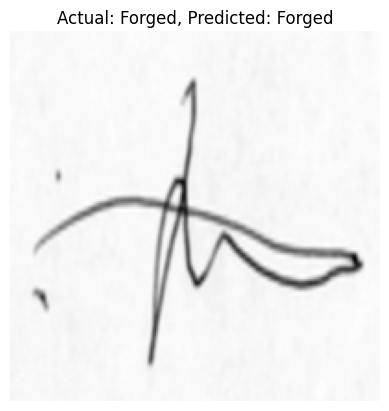

--------------------------------------------------


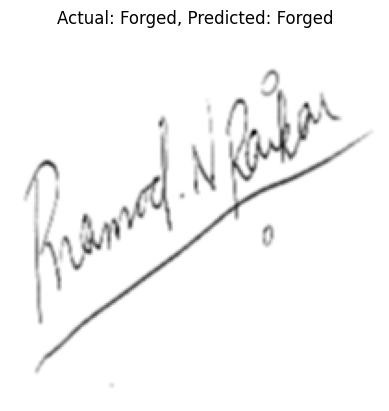

--------------------------------------------------


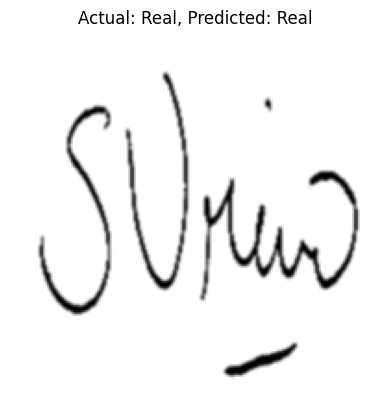

--------------------------------------------------


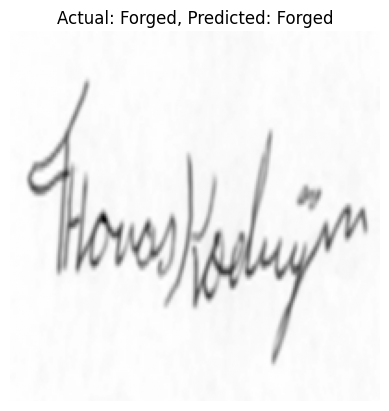

--------------------------------------------------


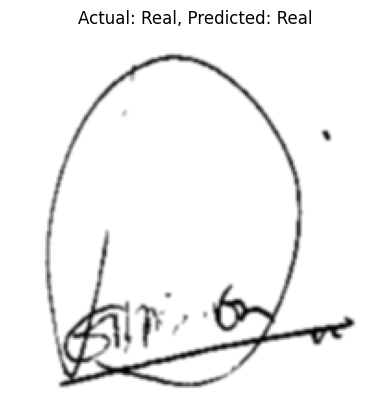

--------------------------------------------------


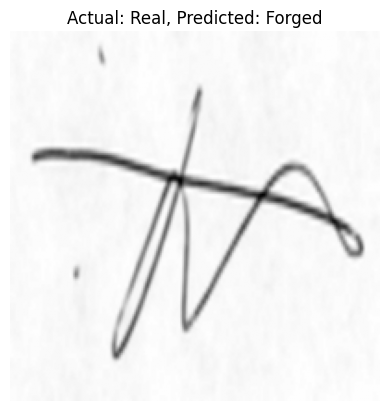

--------------------------------------------------


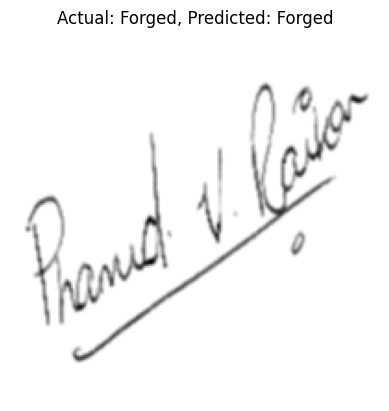

--------------------------------------------------


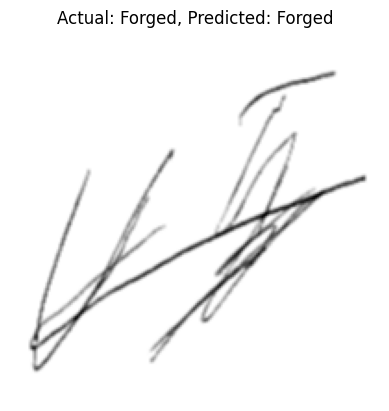

--------------------------------------------------


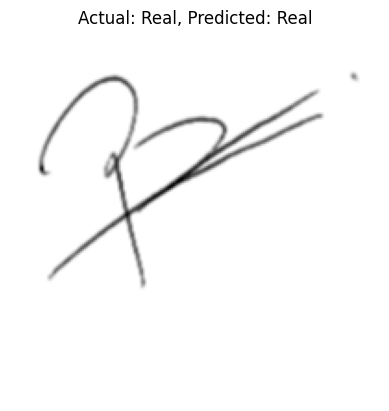

--------------------------------------------------


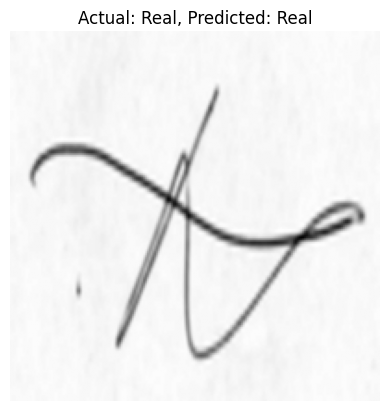

--------------------------------------------------


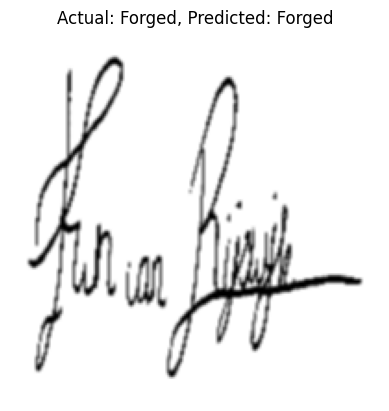

--------------------------------------------------


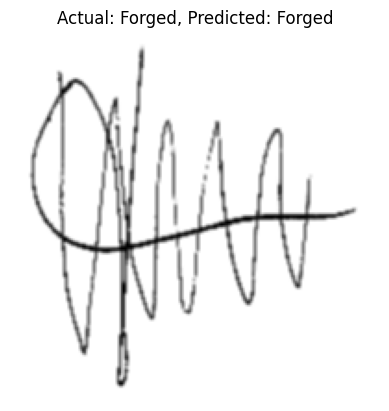

--------------------------------------------------


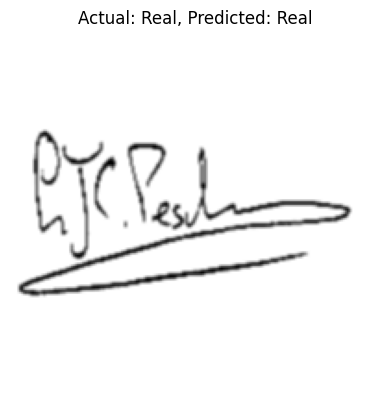

--------------------------------------------------


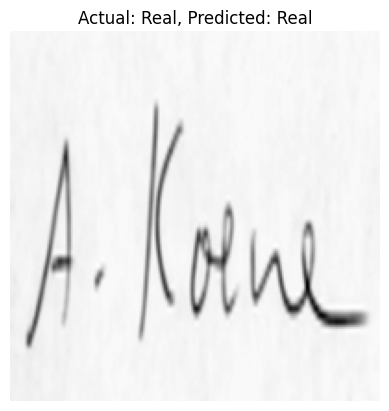

--------------------------------------------------


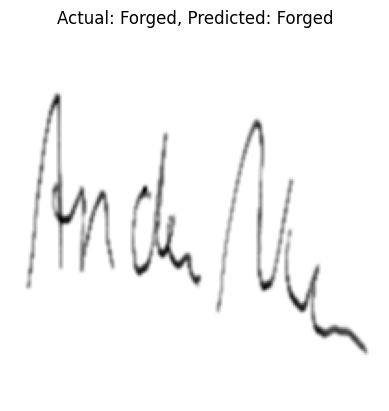

--------------------------------------------------


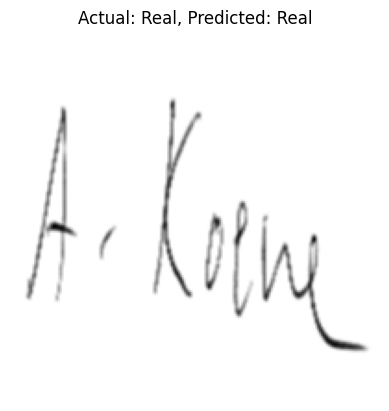

--------------------------------------------------


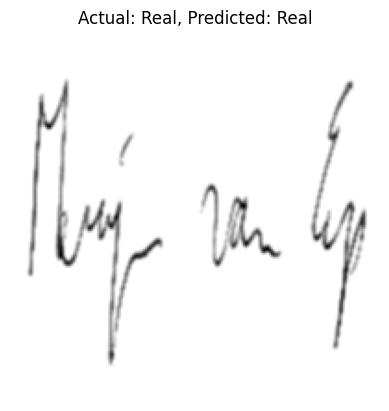

--------------------------------------------------


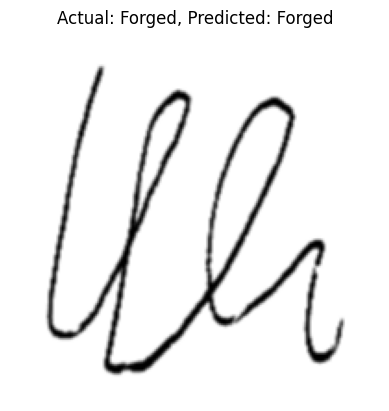

--------------------------------------------------


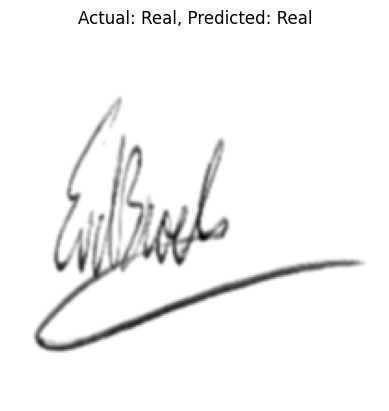

--------------------------------------------------


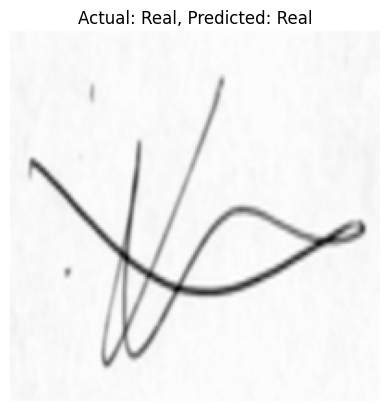

--------------------------------------------------


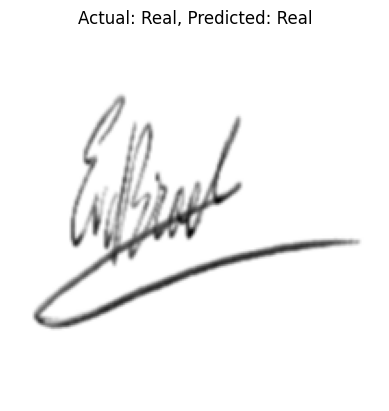

--------------------------------------------------


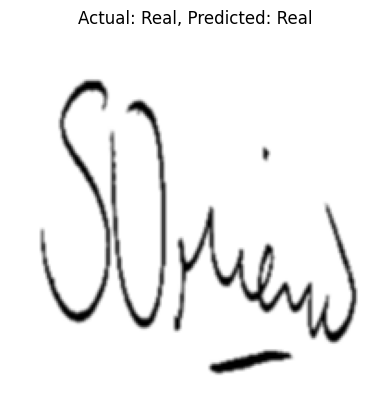

--------------------------------------------------


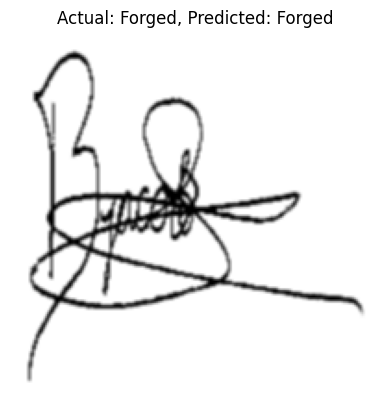

--------------------------------------------------


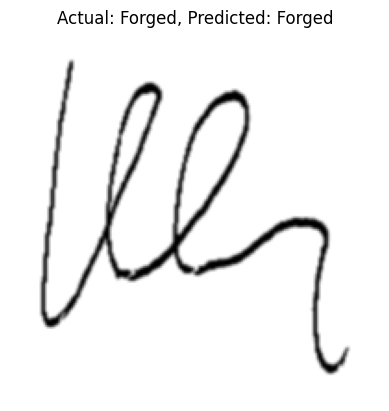

--------------------------------------------------


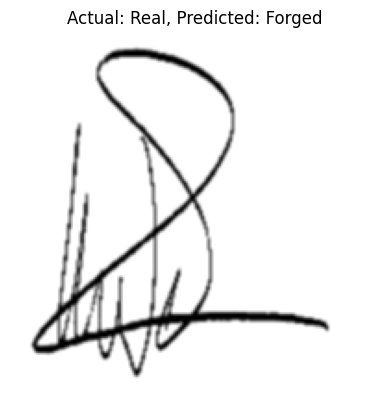

--------------------------------------------------


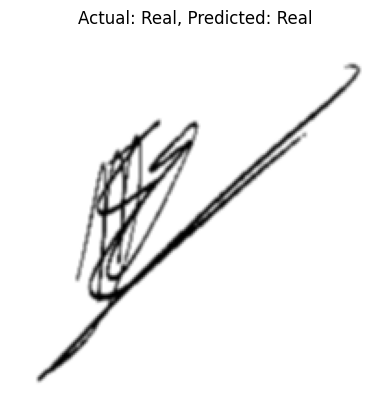

--------------------------------------------------


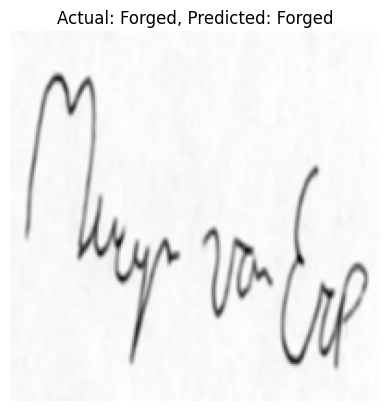

--------------------------------------------------


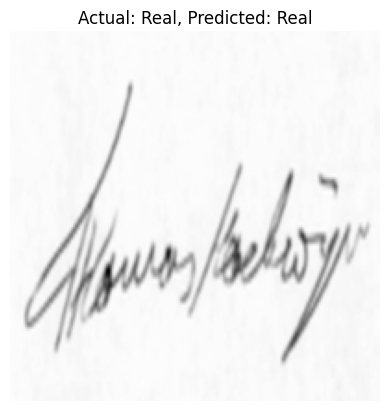

--------------------------------------------------


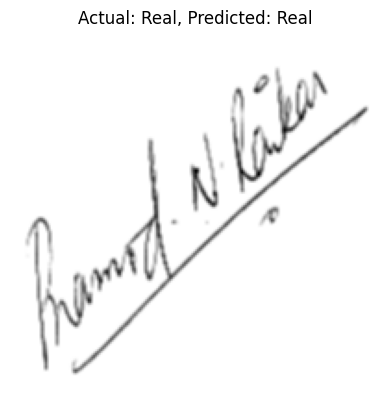

--------------------------------------------------


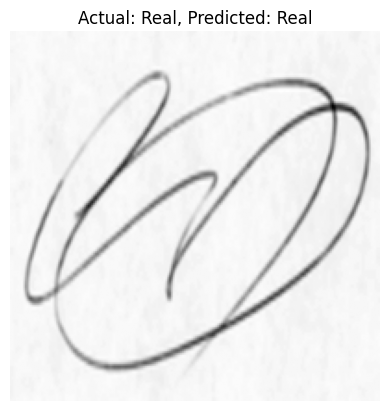

--------------------------------------------------


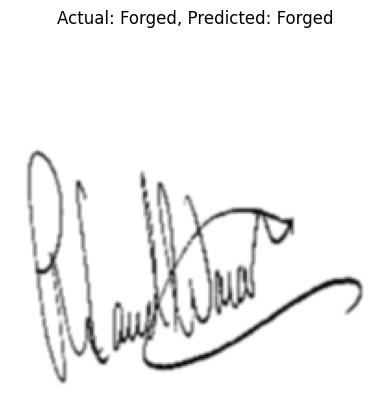

--------------------------------------------------


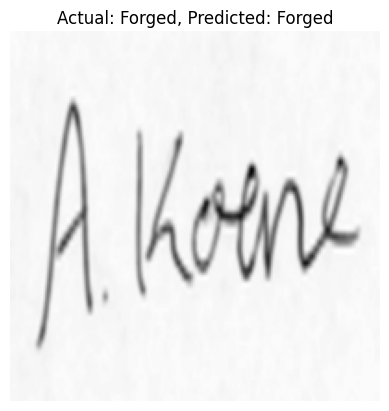

--------------------------------------------------


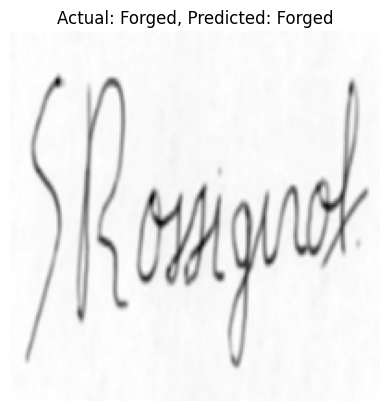

--------------------------------------------------


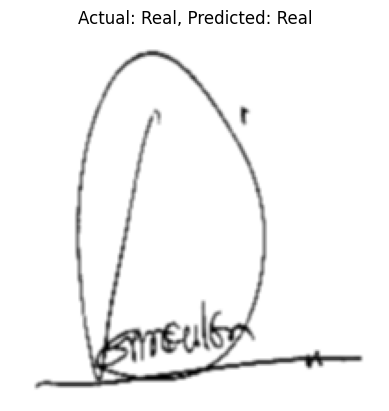

--------------------------------------------------


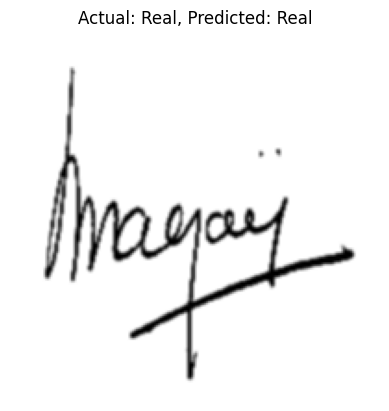

--------------------------------------------------


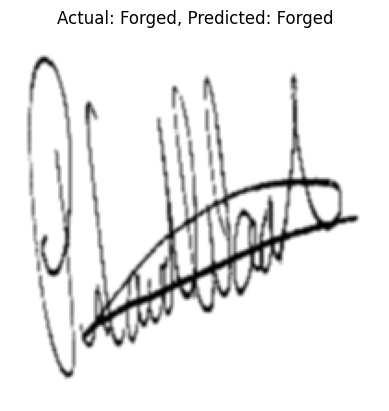

--------------------------------------------------


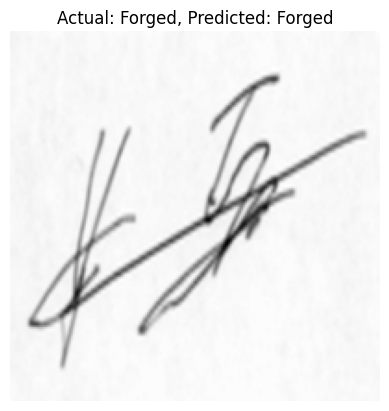

--------------------------------------------------


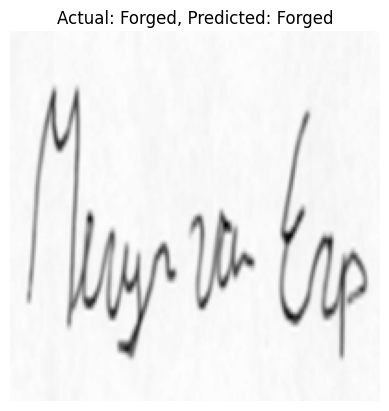

--------------------------------------------------


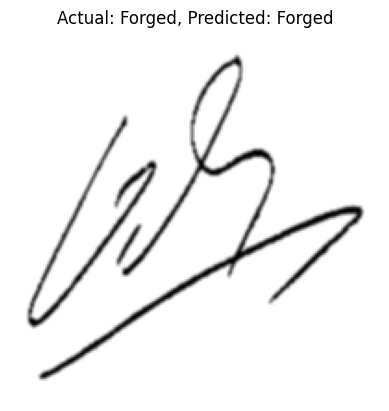

--------------------------------------------------


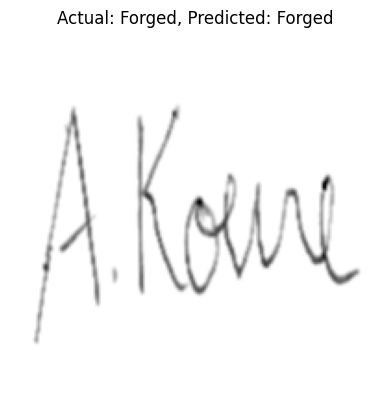

--------------------------------------------------


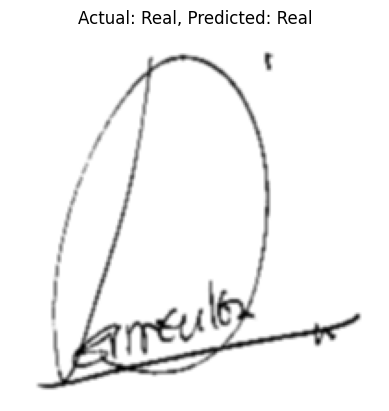

--------------------------------------------------


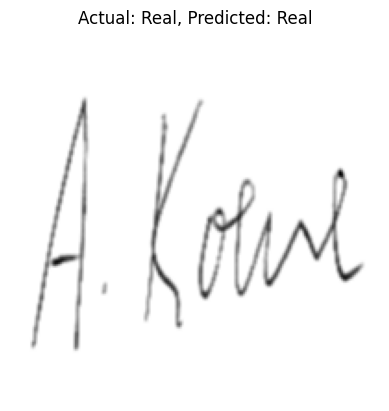

--------------------------------------------------


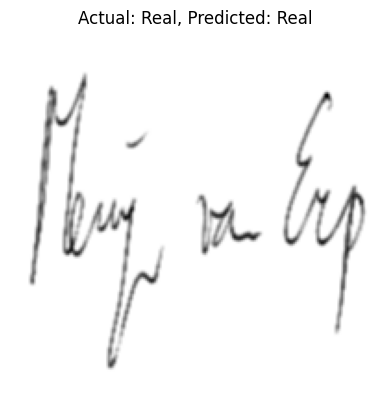

--------------------------------------------------


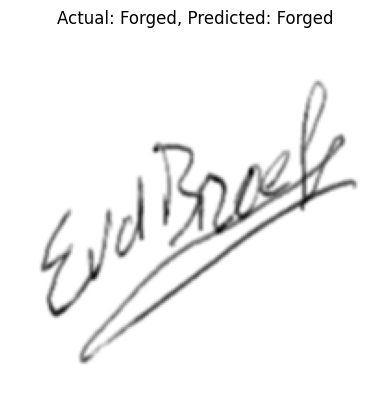

--------------------------------------------------


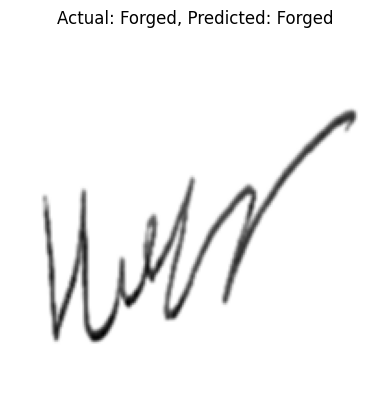

--------------------------------------------------


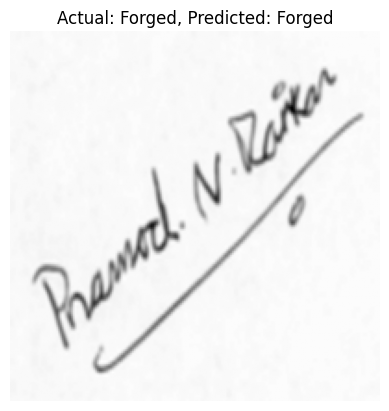

--------------------------------------------------


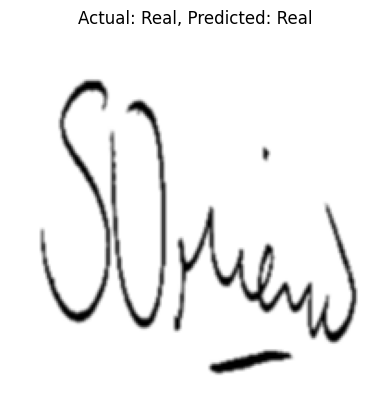

--------------------------------------------------


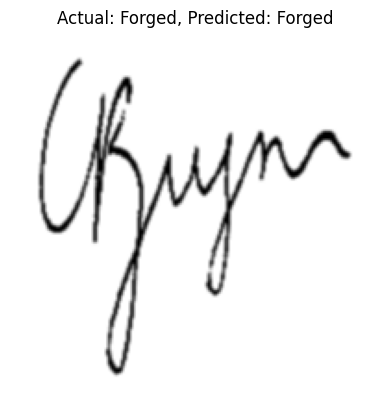

--------------------------------------------------


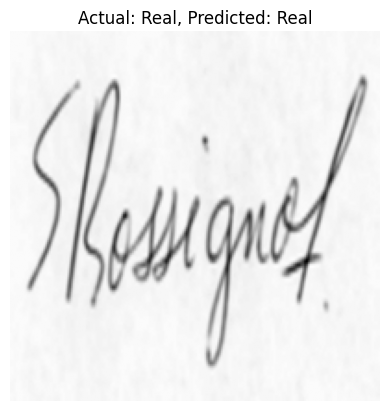

--------------------------------------------------


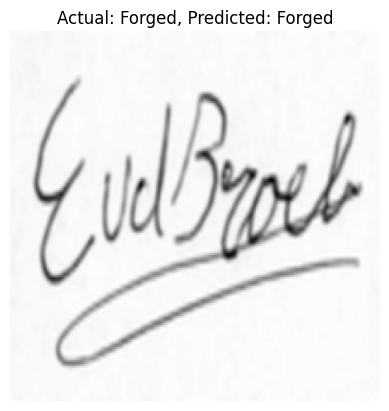

--------------------------------------------------


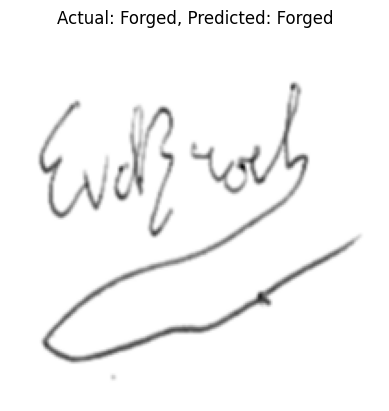

--------------------------------------------------


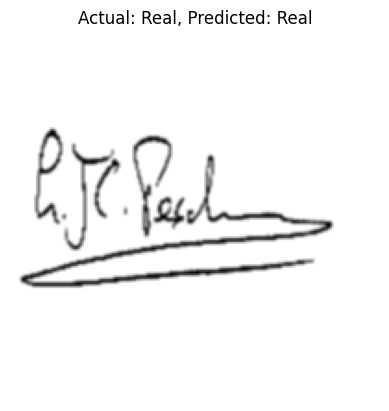

--------------------------------------------------


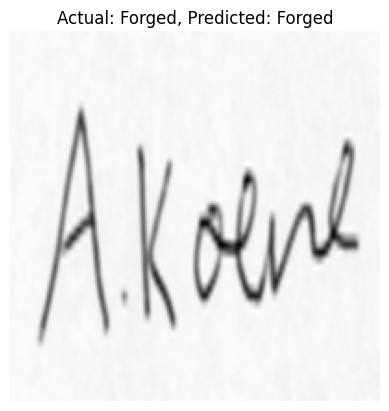

--------------------------------------------------


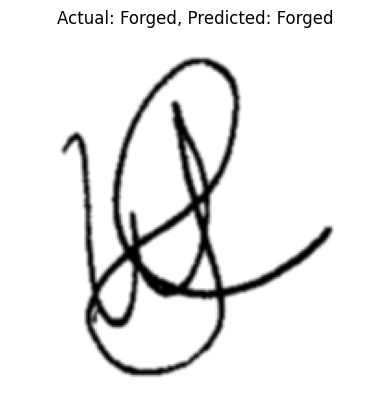

--------------------------------------------------


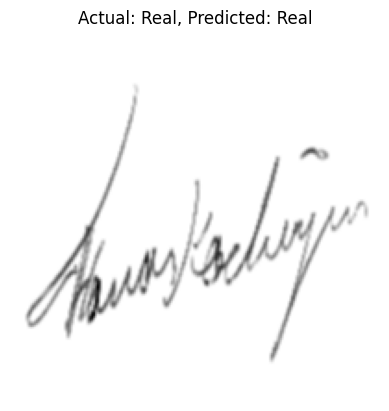

--------------------------------------------------


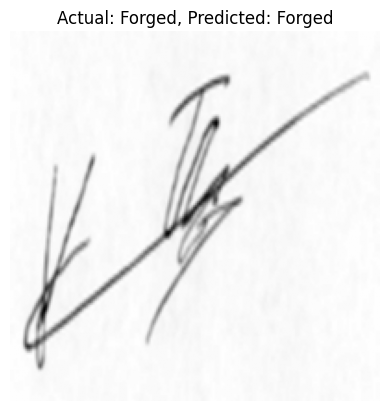

--------------------------------------------------


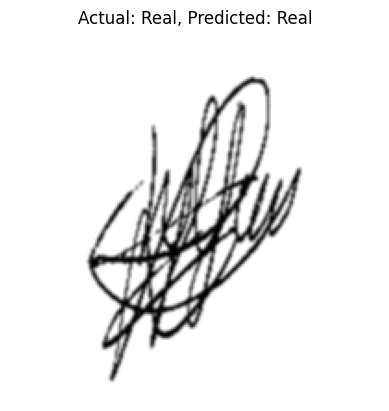

--------------------------------------------------


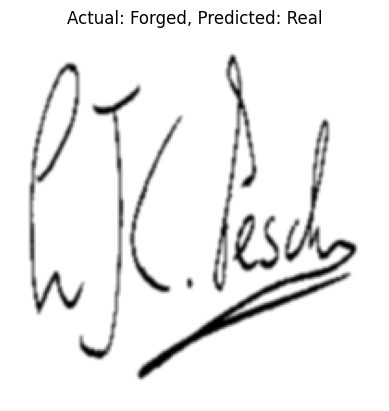

--------------------------------------------------


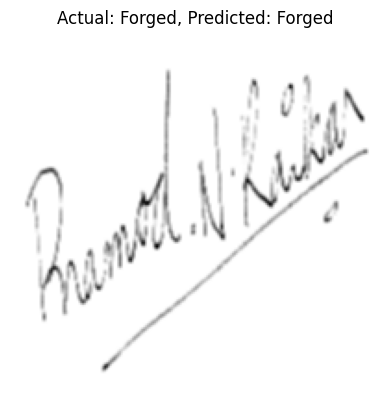

--------------------------------------------------


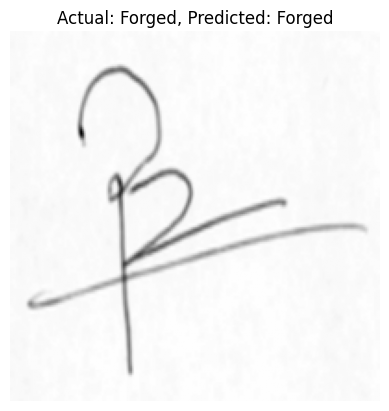

--------------------------------------------------


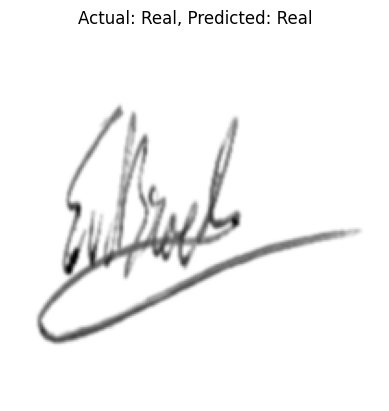

--------------------------------------------------


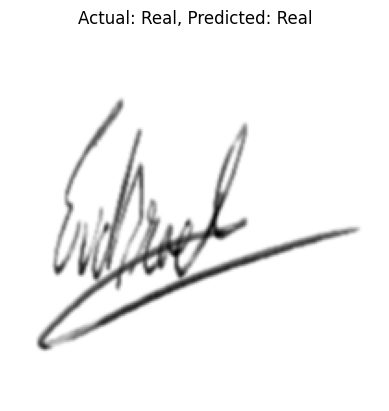

--------------------------------------------------


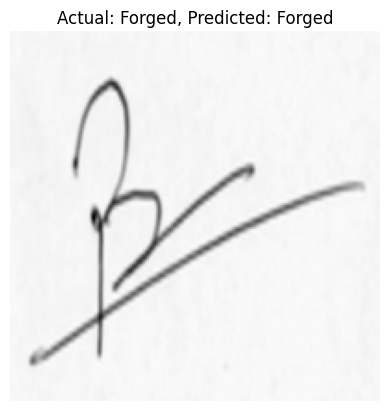

--------------------------------------------------


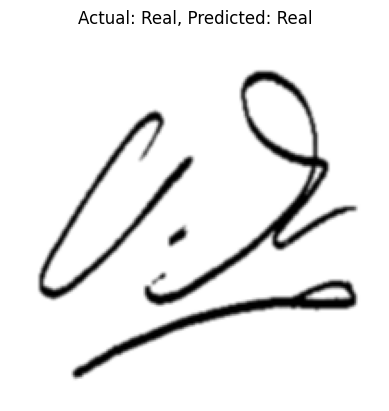

--------------------------------------------------


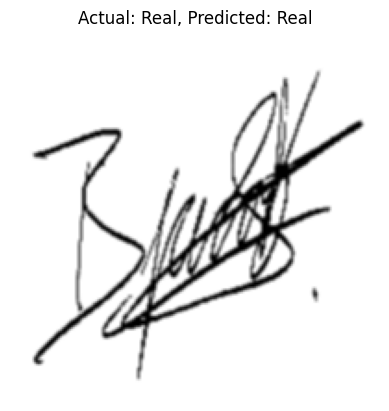

--------------------------------------------------


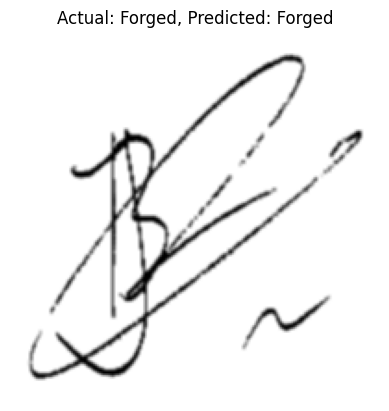

--------------------------------------------------


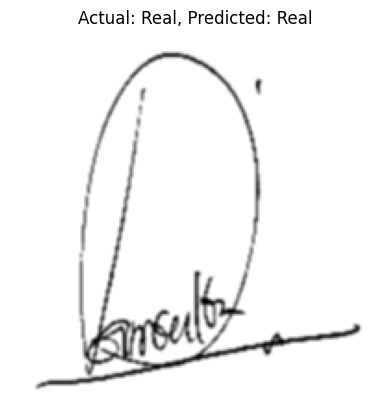

--------------------------------------------------


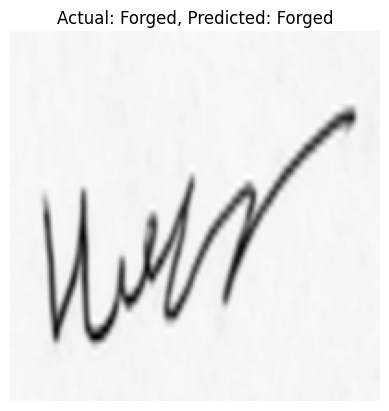

--------------------------------------------------


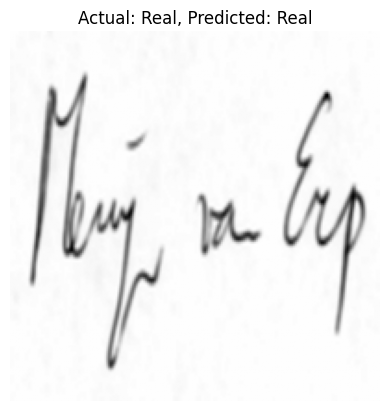

--------------------------------------------------


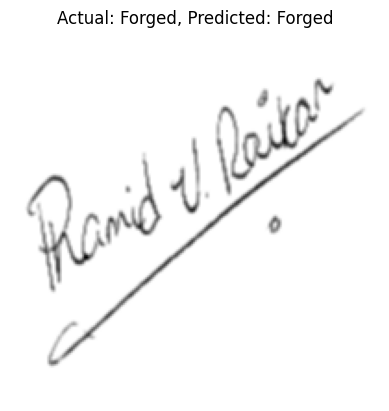

--------------------------------------------------


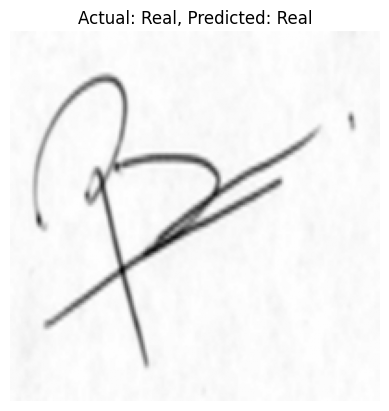

--------------------------------------------------


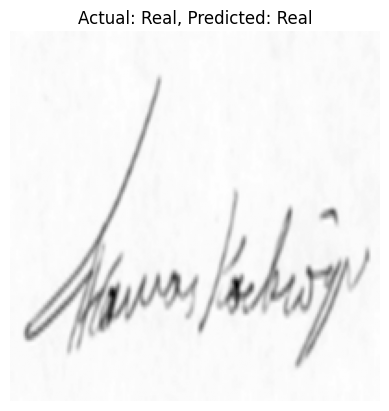

--------------------------------------------------


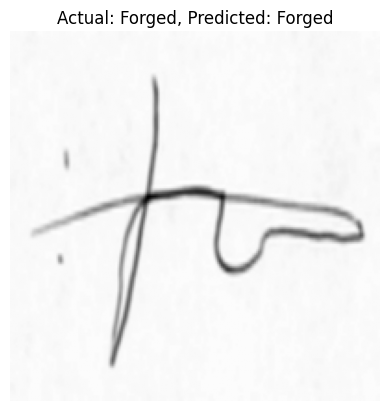

--------------------------------------------------


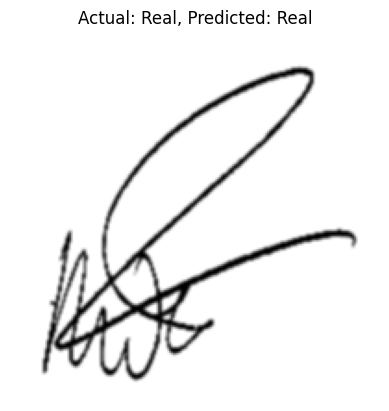

--------------------------------------------------


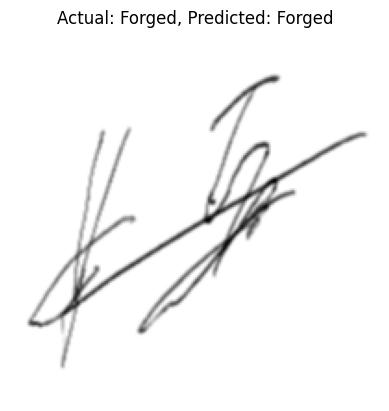

--------------------------------------------------


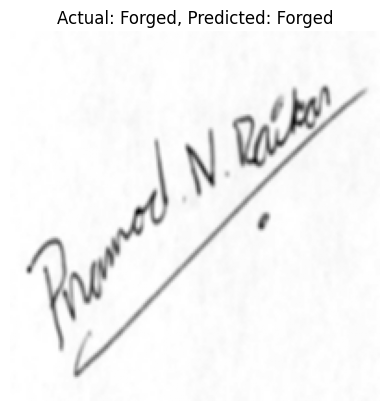

--------------------------------------------------


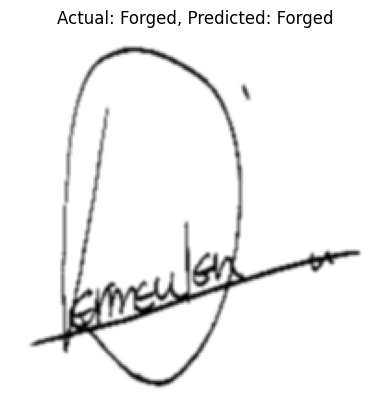

--------------------------------------------------


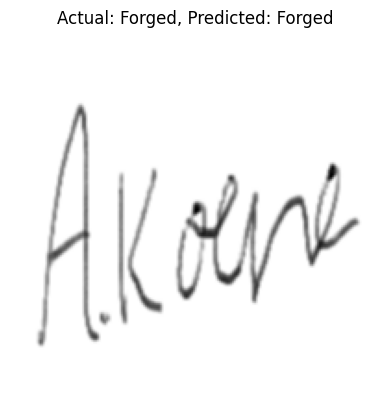

--------------------------------------------------


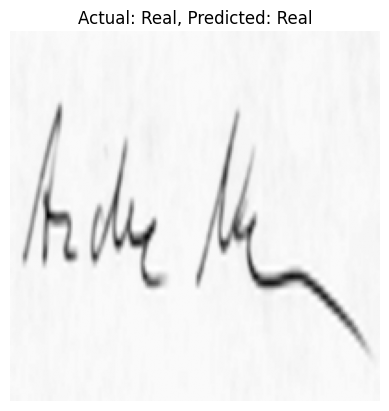

--------------------------------------------------


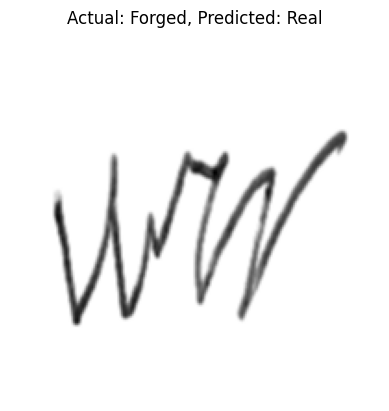

--------------------------------------------------


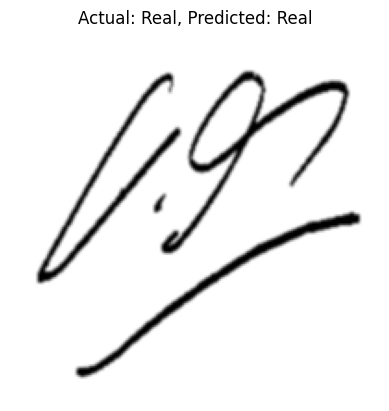

--------------------------------------------------


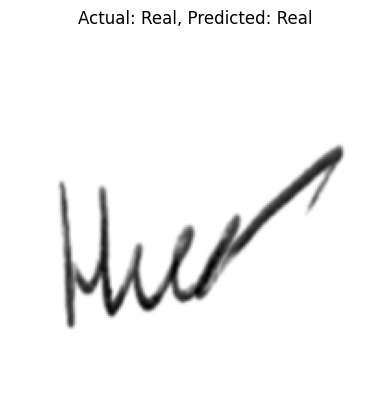

--------------------------------------------------


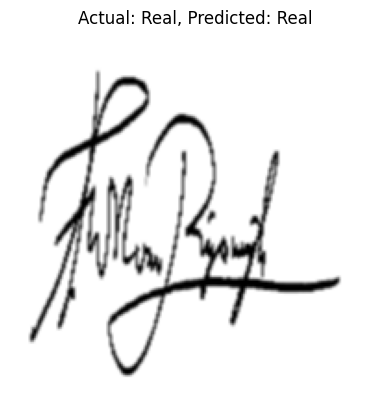

--------------------------------------------------


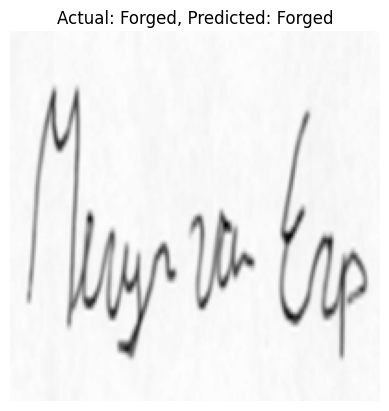

--------------------------------------------------


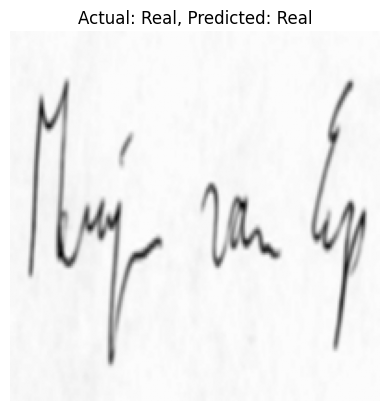

--------------------------------------------------


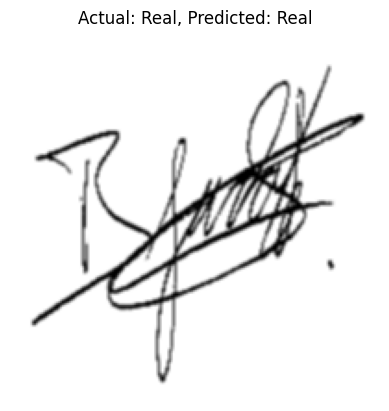

--------------------------------------------------


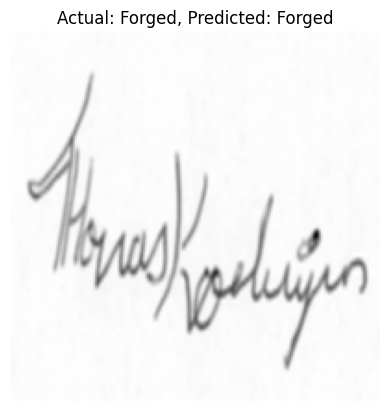

--------------------------------------------------


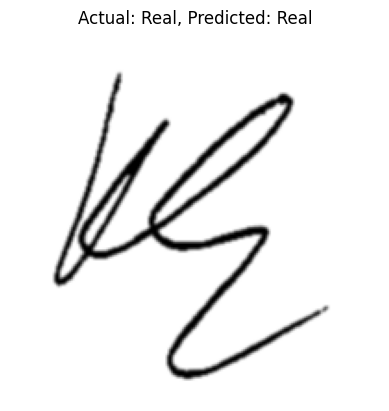

--------------------------------------------------


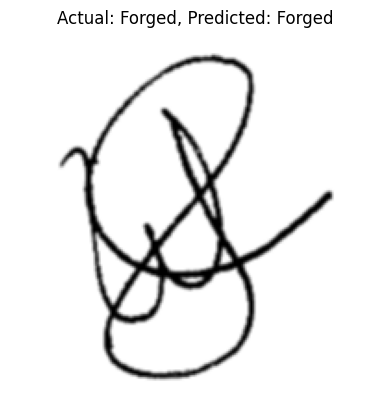

--------------------------------------------------


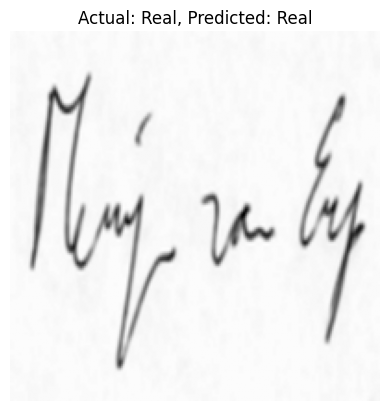

--------------------------------------------------


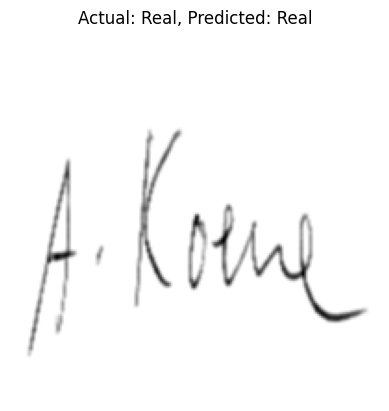

--------------------------------------------------


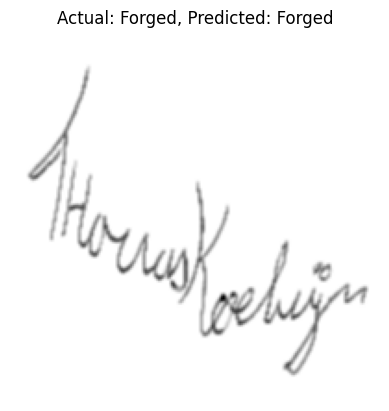

--------------------------------------------------


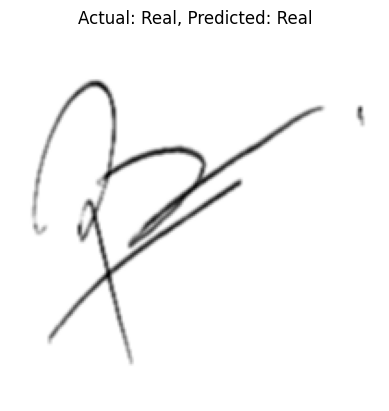

--------------------------------------------------


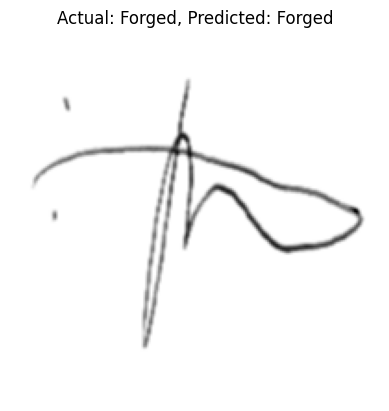

--------------------------------------------------


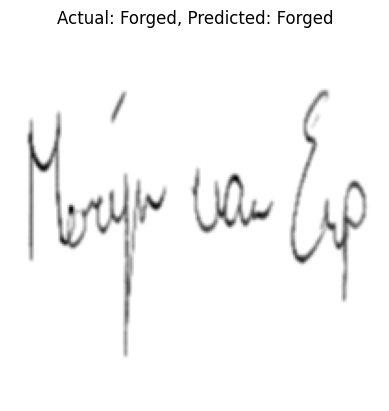

--------------------------------------------------


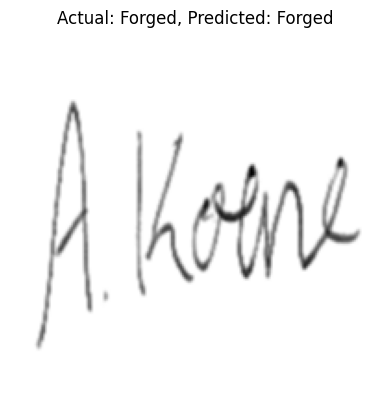

--------------------------------------------------


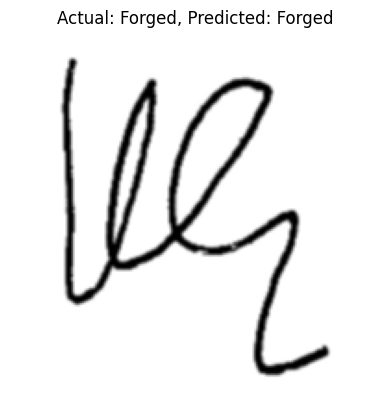

--------------------------------------------------


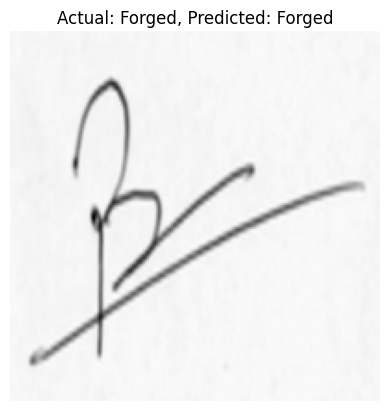

--------------------------------------------------


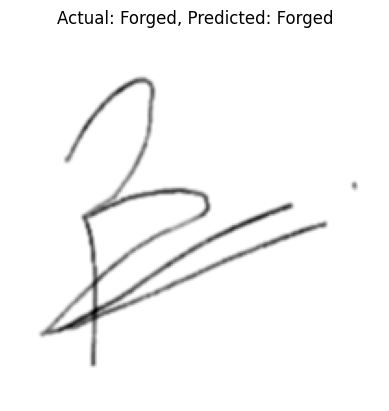

--------------------------------------------------


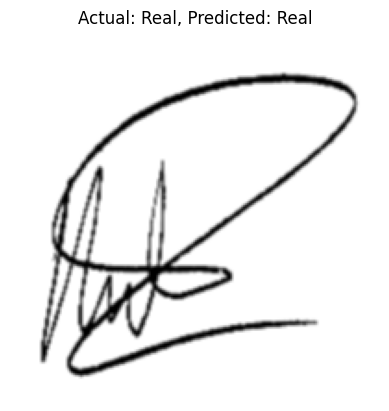

--------------------------------------------------


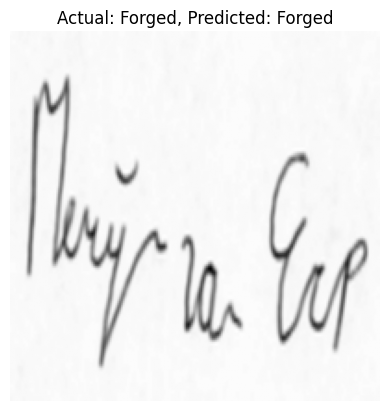

--------------------------------------------------


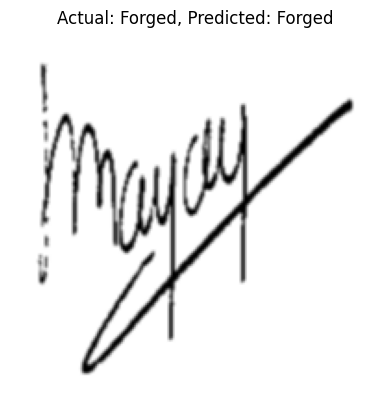

--------------------------------------------------


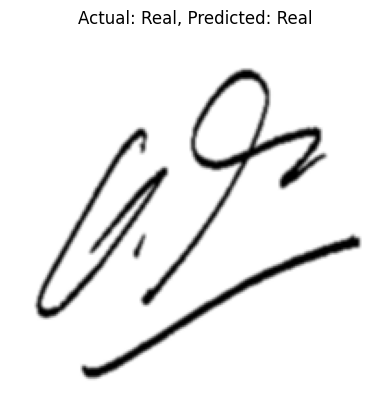

--------------------------------------------------


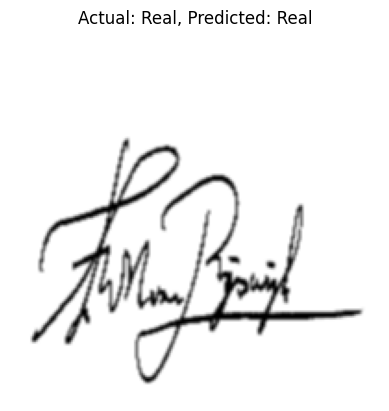

--------------------------------------------------


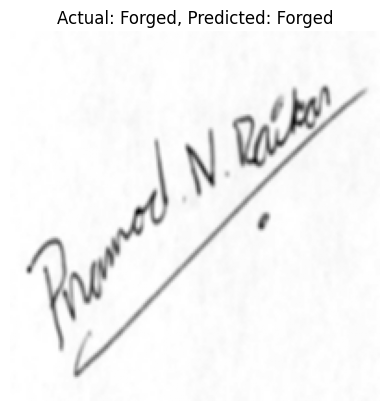

--------------------------------------------------


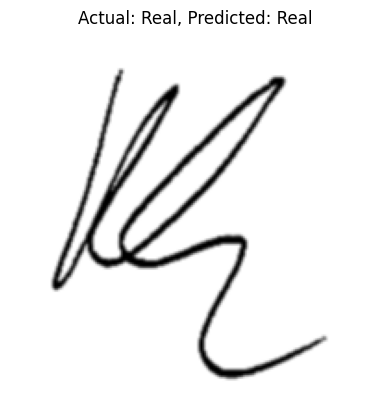

--------------------------------------------------


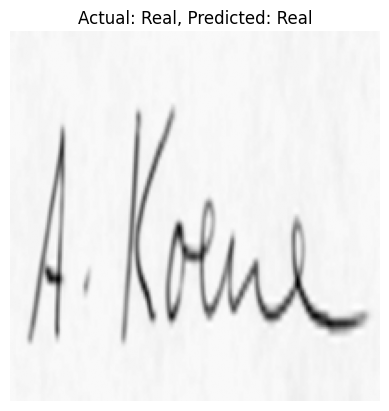

--------------------------------------------------


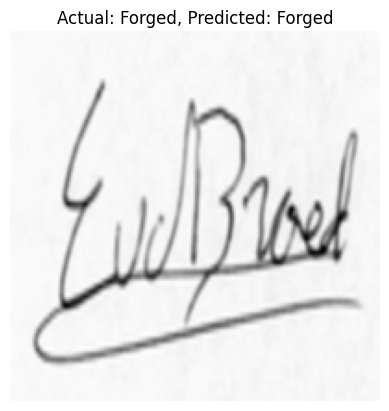

--------------------------------------------------


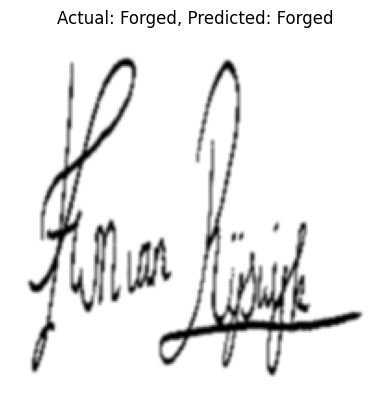

--------------------------------------------------


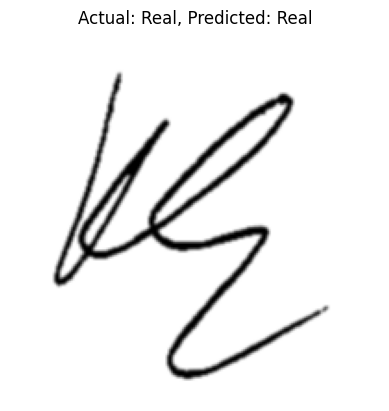

--------------------------------------------------


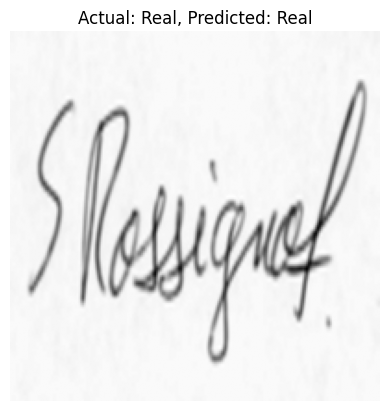

--------------------------------------------------


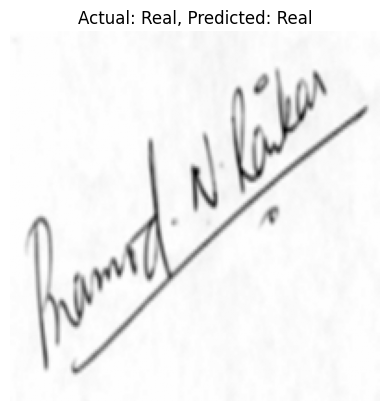

--------------------------------------------------


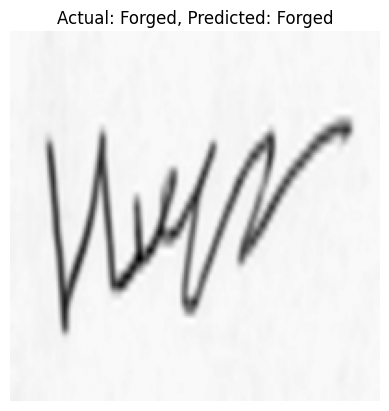

--------------------------------------------------


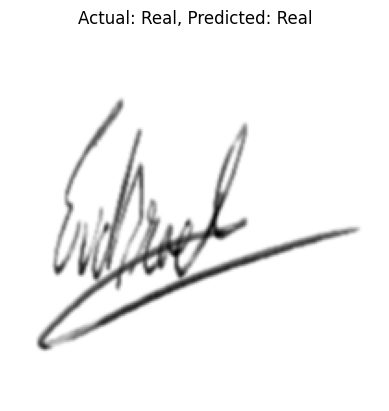

--------------------------------------------------


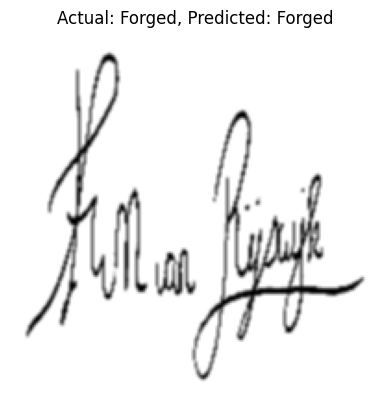

--------------------------------------------------


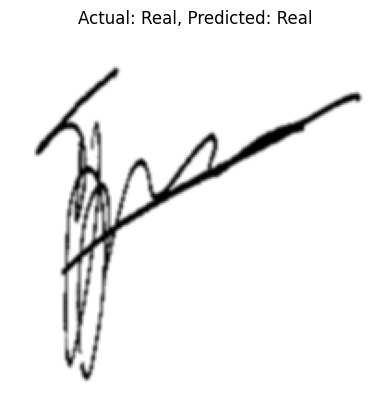

--------------------------------------------------


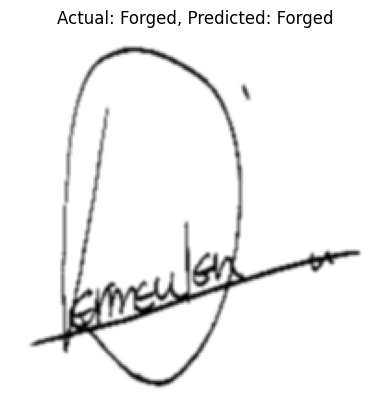

--------------------------------------------------


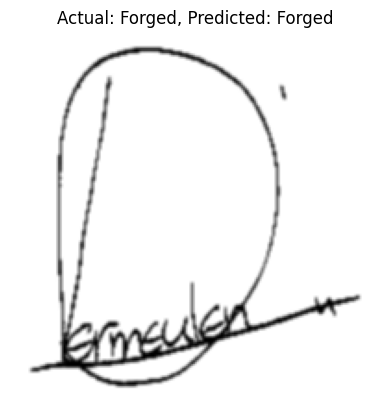

--------------------------------------------------


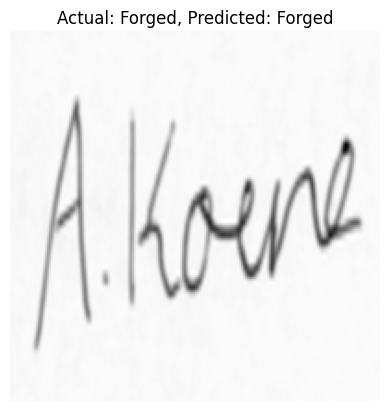

--------------------------------------------------


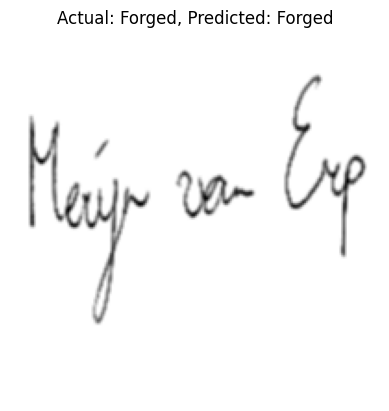

--------------------------------------------------


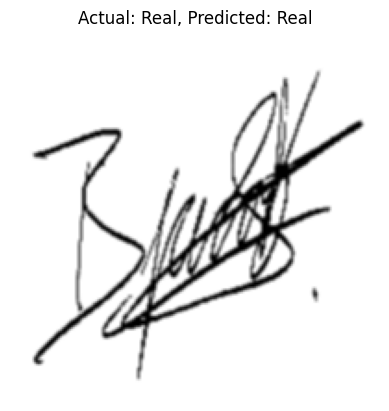

--------------------------------------------------


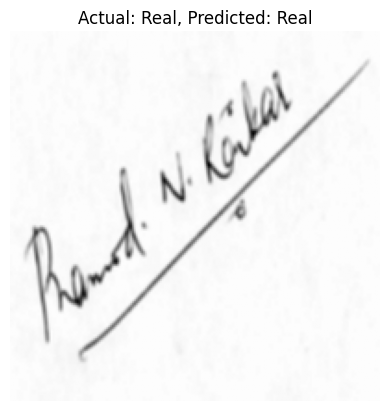

--------------------------------------------------


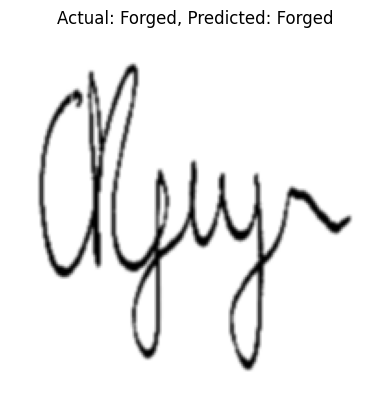

--------------------------------------------------


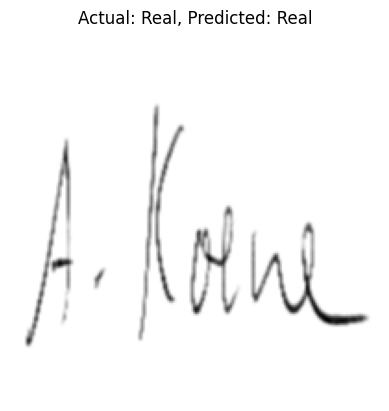

--------------------------------------------------


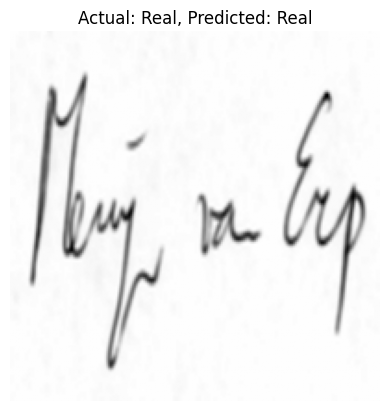

--------------------------------------------------


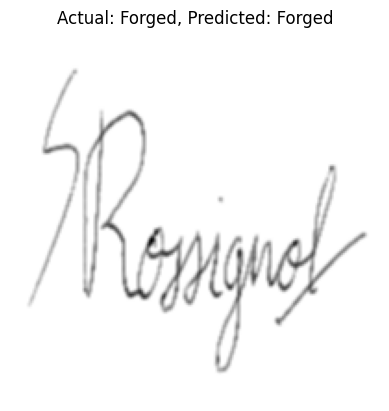

--------------------------------------------------


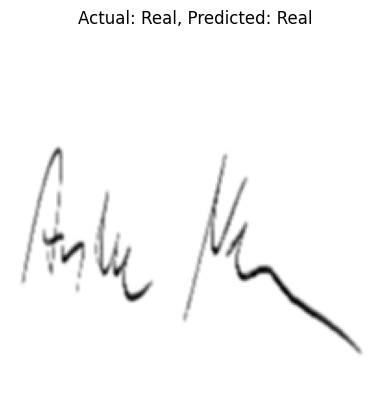

--------------------------------------------------


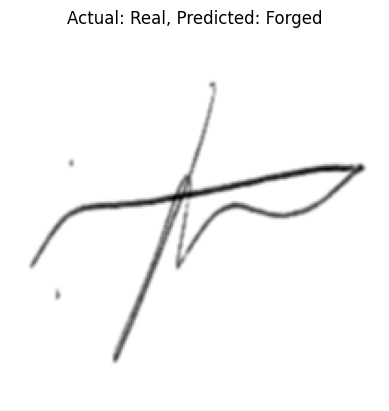

--------------------------------------------------


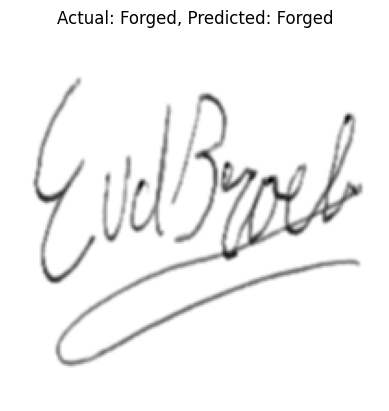

--------------------------------------------------


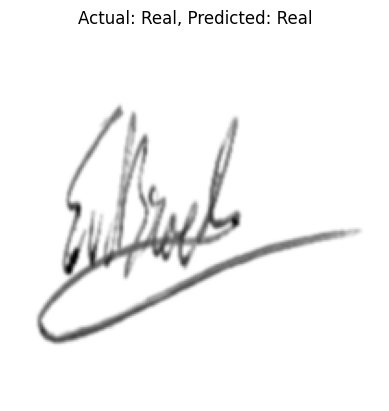

--------------------------------------------------


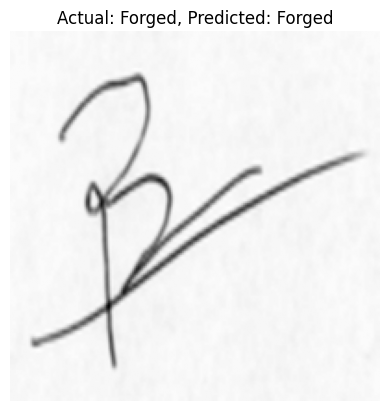

--------------------------------------------------


In [17]:
for i in range(len(y_test)):
    actual = 'Real' if y_test[i] == 0 else 'Forged'
    predicted = 'Real' if y_test_pred[i] == 0 else 'Forged'

    img = img_test[i]

    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f"Actual: {actual}, Predicted: {predicted}")
    plt.show()

    print("-" * 50)

<a id="8"></a>
# <font size= '6' color='DodgerBlue'>▶ Plot Confusion Matrix for Model Evaluation</font>

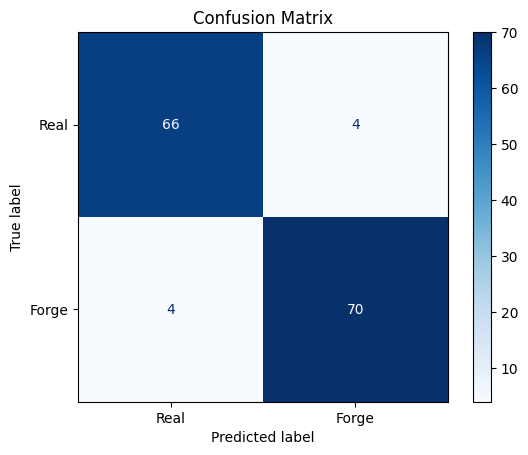

In [18]:
cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Forge'])
fig, ax = plt.subplots()
disp.plot(cmap="Blues", ax=ax)
ax.grid(False)
plt.title("Confusion Matrix")
plt.show()


<a id="8"></a>
# <font size= '6' color='DodgerBlue'>▶ Display Classification Report for Model Evaluation</font>

In [19]:
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94        70
           1       0.95      0.95      0.95        74

    accuracy                           0.94       144
   macro avg       0.94      0.94      0.94       144
weighted avg       0.94      0.94      0.94       144



<a id="8"></a>
# <font size= '6' color='DodgerBlue'>▶ Model Evaluation Metrics</font>

In [20]:
# Precision = TP / (TP + FP)
Precision = precision_score(y_test, y_test_pred)
print(f"➤➤➤ Precision Score : {Precision * 100 : .2f} %\n")

# Recall = TP / (TP + FN)
Recall = recall_score(y_test, y_test_pred)
print(f"➤➤➤ Recall Score : {Recall * 100 : .2f} %\n")

# F1 Score = 2 × ((Precision * Recall) / (Precision + Recall))
F1_Score = f1_score(y_test, y_test_pred)
print(f"➤➤➤ F1 Score : {F1_Score * 100 : .2f} %\n")

➤➤➤ Precision Score :  94.59 %

➤➤➤ Recall Score :  94.59 %

➤➤➤ F1 Score :  94.59 %



<a id="8"></a>
# <font size= '6' color='DodgerBlue'>▶ Testing By Using a New Dataset</font>

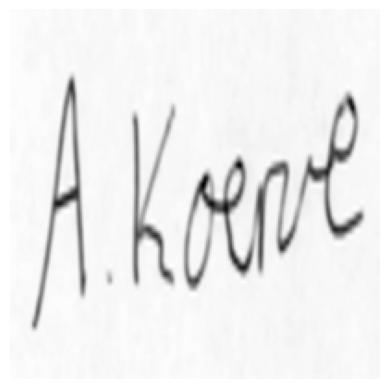

Prediction: Forge


In [22]:
def predict_single_image(model, pca, image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (200, 200))
    img = cv2.GaussianBlur(img, (3, 3), 0)

    hog_features = hog(img, pixels_per_cell=(8, 8), orientations=9,
                       cells_per_block=(2, 2), block_norm='L2-Hys')

    hog_features = hog_features.reshape(1, -1) # Convert extracted features to a 2D array
    hog_pca = pca.transform(hog_features)

    # Return an array with one number (0 or 1) inside it ... But i need this number only
    prediction = model.predict(hog_pca)[0]

    label = 'Real' if prediction == 0 else 'Forge'

    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()
    print(f"Prediction: {label}")

# Using "Testing Dataset" Folder
image_path = "/content/drive/MyDrive/handwritten-signatures/sample_Signature/sample_Signature/forged/NFI-00101014.png"
predict_single_image(model, pca, image_path)